### Mount drive for Google CoLab

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Import all the necessary modules

In [ ]:
import torch
import matplotlib.pylab as plt
from torch.utils.data import Dataset
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision.models import resnet18, ResNet18_Weights, efficientnet_b1, EfficientNet_B1_Weights, squeezenet1_1, SqueezeNet1_1_Weights, shufflenet_v2_x2_0, ShuffleNet_V2_X2_0_Weights, resnet34, ResNet34_Weights
from torchvision import transforms
from torch.optim.lr_scheduler import ExponentialLR


### Now let's setup device agnostic code


In [ ]:
# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


## Define data

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("/content/drive/MyDrive/ENSF645_FinalProject/Project_Dataset/") # directory for Colab
# data_path = Path("Project_Dataset/") # directory for VSCode
image_path = data_path 

In [ ]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 3 directories and 0 images in '/content/drive/MyDrive/ENSF645_FinalProject/Project_Dataset'.
There are 3 directories and 0 images in '/content/drive/MyDrive/ENSF645_FinalProject/Project_Dataset/test'.
There are 0 directories and 42 images in '/content/drive/MyDrive/ENSF645_FinalProject/Project_Dataset/test/healthy'.
There are 0 directories and 43 images in '/content/drive/MyDrive/ENSF645_FinalProject/Project_Dataset/test/bean_rust'.
There are 0 directories and 43 images in '/content/drive/MyDrive/ENSF645_FinalProject/Project_Dataset/test/angular_leaf_spot'.
There are 3 directories and 0 images in '/content/drive/MyDrive/ENSF645_FinalProject/Project_Dataset/train'.
There are 0 directories and 345 images in '/content/drive/MyDrive/ENSF645_FinalProject/Project_Dataset/train/angular_leaf_spot'.
There are 0 directories and 348 images in '/content/drive/MyDrive/ENSF645_FinalProject/Project_Dataset/train/bean_rust'.
There are 0 directories and 342 images in '/content/drive/MyDrive/E

In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"
val_dir = image_path / "validation"

train_dir, test_dir, val_dir

(PosixPath('/content/drive/MyDrive/ENSF645_FinalProject/Project_Dataset/train'),
 PosixPath('/content/drive/MyDrive/ENSF645_FinalProject/Project_Dataset/test'),
 PosixPath('/content/drive/MyDrive/ENSF645_FinalProject/Project_Dataset/validation'))

## Visualize an Image

A major process in any machine learning experiment is to "know the data".  We know that we have a variety of images in the dataset so lets have a look at one....

Random image path: /content/drive/MyDrive/ENSF645_FinalProject/Project_Dataset/train/angular_leaf_spot/angular_leaf_spot_train.220.jpg
Image class: angular_leaf_spot
Image height: 500
Image width: 500


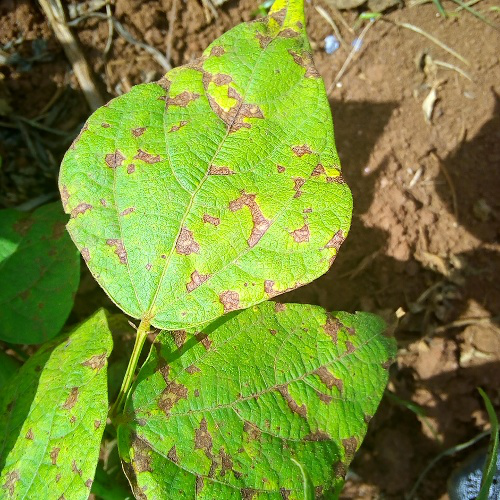

In [ ]:
import random
from PIL import Image
from pathlib import Path

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.*"))
image_path_list

#2. Get random image path
random_image_path = random.choice(image_path_list)

# # 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# # 4. Open image
img = Image.open(random_image_path)

# # 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

## Selecting Model
Selecting the pretrained model and weights.

In [ ]:
# selected_model=resnet18
# pretrained_weights=ResNet18_Weights.IMAGENET1K_V1

# selected_model=efficientnet_b1
# pretrained_weights=EfficientNet_B1_Weights.IMAGENET1K_V2

# selected_model=squeezenet1_1
# pretrained_weights=SqueezeNet1_1_Weights.IMAGENET1K_V1

# selected_model=shufflenet_v2_x2_0
# pretrained_weights=ShuffleNet_V2_X2_0_Weights.IMAGENET1K_V1

selected_model=resnet34
pretrained_weights=ResNet34_Weights.IMAGENET1K_V1




## Defining the transforms

In [ ]:
def plot_images(imgs, orig_img=None, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    with_orig=True if orig_img is not None else False

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False, figsize=(12, 12))
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set_ylabel(row_title[row_idx], rotation=0, labelpad=65)

    

### Exploring random transforms

Random transforms can change the image in various ways to hopefully help the model generalize better. We will explore some transforms to see how it affects our data. More transforms can be found here https://pytorch.org/vision/main/auto_examples/plot_transforms.html

In [ ]:
augmenters = [transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), 
              transforms.RandomPerspective(), transforms.RandomRotation(degrees=(0,360)), transforms.RandomAutocontrast(), transforms.RandomInvert(),
              transforms.RandomAdjustSharpness(sharpness_factor=2), transforms.ColorJitter(brightness=0.15, saturation=0.15, contrast=0.15)]

orig_img=Image.open("Project_Dataset\\train\\angular_leaf_spot\\angular_leaf_spot_train.189.jpg")

imgs = [
    [augmenter(orig_img) for _ in range(5)]
    for augmenter in augmenters
]
row_title = [transform._get_name() for transform in augmenters]
plot_images(imgs, orig_img=orig_img, row_title=row_title)

FileNotFoundError: ignored

For computational efficiency and faster training, as well as to ensure important image features such as color don't change too much, only RandomHorizontalFlip abd RandomRotation will be selected.

For training, we will first augment the data with our selected random transformations, followed by the same standard transforms used in the training of the selected model. For testing, only the standard model transforms will be applied.

In [ ]:
torchvision_transform = torch.nn.Sequential(transforms.RandomHorizontalFlip(), transforms.RandomRotation(degrees=(0,360)),
                                            pretrained_weights.transforms())

torchvision_transform_test = pretrained_weights.transforms()

### Visualizing some of the transformed images

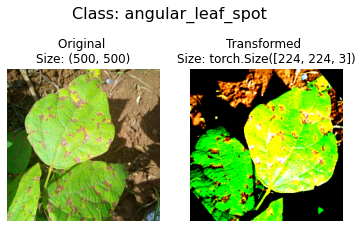

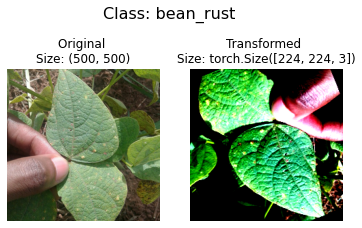

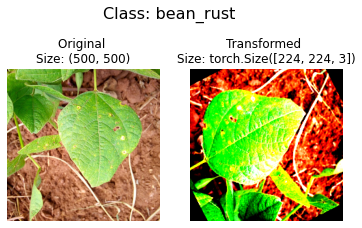

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=torchvision_transform, 
                        n=3)

## Creating the datasets

In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=torchvision_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

val_data = datasets.ImageFolder(root=val_dir, 
                                 transform=torchvision_transform)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=torchvision_transform_test)

print(f"Train data:\n{train_data}\nValidation data:\n{val_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 1034
    Root location: /content/drive/MyDrive/ENSF645_FinalProject/Project_Dataset/train
    StandardTransform
Transform: Sequential(
             (0): RandomHorizontalFlip(p=0.5)
             (1): RandomRotation(degrees=[0.0, 360.0], interpolation=nearest, expand=False, fill=0)
             (2): ImageClassification(
                 crop_size=[224]
                 resize_size=[256]
                 mean=[0.485, 0.456, 0.406]
                 std=[0.229, 0.224, 0.225]
                 interpolation=InterpolationMode.BILINEAR
             )
           )
Validation data:
Dataset ImageFolder
    Number of datapoints: 133
    Root location: /content/drive/MyDrive/ENSF645_FinalProject/Project_Dataset/validation
    StandardTransform
Transform: Sequential(
             (0): RandomHorizontalFlip(p=0.5)
             (1): RandomRotation(degrees=[0.0, 360.0], interpolation=nearest, expand=False, fill=0)
             (2): ImageClassifica

In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['angular_leaf_spot', 'bean_rust', 'healthy']

In [ ]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2}

In [ ]:
# Check the lengths
len(train_data), len(test_data)

(1034, 128)

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[ 0.4337,  0.2624,  0.1083,  ..., -0.9192, -0.8678, -0.7650],
         [ 0.3138,  0.1254, -0.0629,  ..., -0.4739, -0.5082, -0.5082],
         [ 0.2111, -0.0287, -0.1486,  ..., -0.2171, -0.4911, -0.3712],
         ...,
         [-1.2617, -1.3473, -1.3815,  ...,  1.3927,  1.3584,  1.1872],
         [-1.3302, -1.2788, -1.2959,  ...,  1.3584,  1.2214,  1.1187],
         [-1.5699, -1.4329, -1.3302,  ...,  0.4679,  0.8104,  1.2557]],

        [[ 1.3431,  1.2381,  1.1155,  ..., -0.9153, -0.8277, -0.7577],
         [ 1.1856,  1.0630,  0.9055,  ..., -0.6001, -0.6001, -0.5826],
         [ 1.0280,  0.8179,  0.7304,  ..., -0.4776, -0.7577, -0.6176],
         ...,
         [-1.4755, -1.5630, -1.5980,  ...,  0.7654,  0.8004,  0.6429],
         [-1.5455, -1.4930, -1.5455,  ...,  0.7304,  0.7304,  0.5728],
         [-1.7031, -1.6331, -1.5805,  ..., -0.2675,  0.2577,  0.7304]],

        [[-1.7696, -1.7522, -1.7347,  ..., -1.6999, -1.6999, -1.7173],
         [-1.7173, -1.7696, -1.

## Turn train and test Datasets into DataLoaders

In [ ]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=32, # how many samples per batch?
                              num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

val_dataloader = DataLoader(dataset=val_data, 
                             batch_size=32, 
                             num_workers=0, 
                             shuffle=False) # don't usually need to shuffle testing data

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=32, 
                             num_workers=0, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fe3d3fbad30>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe3d0bcc2e0>)

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 1034
    Root location: /content/drive/MyDrive/ENSF645_FinalProject/Project_Dataset/train
    StandardTransform
Transform: Sequential(
             (0): RandomHorizontalFlip(p=0.5)
             (1): RandomRotation(degrees=[0.0, 360.0], interpolation=nearest, expand=False, fill=0)
             (2): ImageClassification(
                 crop_size=[224]
                 resize_size=[256]
                 mean=[0.485, 0.456, 0.406]
                 std=[0.229, 0.224, 0.225]
                 interpolation=InterpolationMode.BILINEAR
             )
           )

Showing training data statistics and examples

In [ ]:
def get_dataset_stats(data_loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in data_loader:
        data = data[0]  # Get the images to compute the stgatistics
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

print(get_dataset_stats(train_dataloader))

(tensor([-0.0187,  0.3258, -0.4120]), tensor([0.8093, 0.9194, 0.7250]))


In [ ]:
train_iterator = iter(train_dataloader)
train_batch = next(train_iterator)

In [ ]:
print(train_batch[0].size())
print(train_batch[1].size())

torch.Size([32, 3, 224, 224])
torch.Size([32])


## Defining the Model

Defining model extension of nn.Module which will load the selected model's feature extractor and add a linear classifier layer on top.  
This class will load the selected model's pretrained weights if transfer is true. The model will also fix the feature extractor layer and not train the parameters if fixed_feature_extractor is true.

In [62]:
class Model(nn.Module):
    def __init__(self,  num_classes, input_shape, transfer=False, fixed_feature_extractor=False): # applicable to resnet, shufflenet
    # def __init__(self,  num_classes, transfer=False, fixed_feature_extractor=False): # applicable to efficientnet
        super().__init__()

        self.transfer = transfer
        self.num_classes = num_classes
        self.input_shape = input_shape
        
        # loading pretrained_weights if transfer is True
        self.model =  selected_model(weights=(pretrained_weights if transfer else None))

        if fixed_feature_extractor:
            # layers are frozen by using eval()
            self.model.eval()
            
            # freeze params
            for param in self.model.parameters():
                param.requires_grad = False

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes) # applicable to resnet, sufflenet
        # self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes) # applicable efficientnet

    # will be used during inference
    def forward(self, x):
       x = self.model(x)
       return x
    
    def unfix_feature_extractor(self):
        # layers are unfrozen by using train()
        self.model.train()

        # unfreeze params
        for param in self.model.parameters():
            param.requires_grad = True

Creating a model which will load the pretrained weights and fix the feature extractor parameters, only training the classifier.

In [63]:
net = Model(3, (3,224,224), transfer=True, fixed_feature_extractor=True)
#net = Model(3, transfer=True, fixed_feature_extractor=True) # applicable to efficientnet
net.to(device)

Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

## Training

### Classifier training

Defining the criterion, optimizer, and scheduler

In [64]:
# CrossEntropyLoss for classification
criterion = nn.CrossEntropyLoss()

# selecting optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.08, momentum=0.9)

# exponential schedule will multiply the learning rate by gamma after each epoch
scheduler = ExponentialLR(optimizer, gamma=0.98)

Training

In [65]:
PATH = 'EV_net.pth' # Path to save the best model

def train():
    nepochs = 20
    best_loss = 1e+20
    
    for epoch in range(nepochs):  # loop over the dataset multiple times
        # Training Loop
        net.train()
        train_loss = 0.0
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        print(f'{epoch + 1},  train loss: {train_loss / (i+1):.3f},', end = ' ')
        scheduler.step()

        # Validation
        net.eval()
        val_loss = 0
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for i, data in enumerate(val_dataloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
            print(f'val loss: {val_loss / (i+1):.3f}')
            
            # Save best model
            if val_loss < best_loss:
                print("Saving model")
                torch.save(net.state_dict(), PATH)
                best_loss = val_loss
            
    print('Finished Training')

train()

1,  train loss: 6.472, val loss: 3.705
Saving model
2,  train loss: 2.887, val loss: 0.972
Saving model
3,  train loss: 2.730, val loss: 2.189
4,  train loss: 2.107, val loss: 0.906
Saving model
5,  train loss: 2.525, val loss: 2.684
6,  train loss: 3.345, val loss: 2.722
7,  train loss: 3.514, val loss: 2.594
8,  train loss: 2.683, val loss: 1.206
9,  train loss: 2.443, val loss: 1.120
10,  train loss: 1.458, val loss: 1.197
11,  train loss: 1.849, val loss: 0.995
12,  train loss: 2.505, val loss: 0.657
Saving model
13,  train loss: 1.725, val loss: 0.830
14,  train loss: 2.812, val loss: 1.818
15,  train loss: 2.428, val loss: 2.105
16,  train loss: 2.025, val loss: 2.322
17,  train loss: 1.993, val loss: 3.111
18,  train loss: 2.143, val loss: 1.557
19,  train loss: 1.719, val loss: 0.800
20,  train loss: 1.364, val loss: 0.856
Finished Training


### Finetune the feature extractor

In [66]:
PATH = 'EV_net.pth'
# load best model
net.load_state_dict(torch.load(PATH))

# unfreeze the feature extractor
net.unfix_feature_extractor()
net.to(device)

# CrossEntropyLoss for classification
criterion = nn.CrossEntropyLoss()

# selecting optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.00005)

# exponential schedule will multiply the learning rate by gamma after each epoch
scheduler = ExponentialLR(optimizer, gamma=0.90)

# path for finetuned model
PATH = 'EV_net_ft.pth'

# train
train()

1,  train loss: 1.609, val loss: 1.614
Saving model
2,  train loss: 1.154, val loss: 0.170
Saving model
3,  train loss: 0.887, val loss: 0.210
4,  train loss: 0.499, val loss: 0.312
5,  train loss: 0.540, val loss: 0.360
6,  train loss: 0.337, val loss: 0.639
7,  train loss: 0.357, val loss: 0.056
Saving model
8,  train loss: 0.242, val loss: 0.518
9,  train loss: 0.279, val loss: 0.035
Saving model
10,  train loss: 0.146, val loss: 0.415
11,  train loss: 0.174, val loss: 0.269
12,  train loss: 0.229, val loss: 0.303
13,  train loss: 0.106, val loss: 0.232
14,  train loss: 0.188, val loss: 0.353
15,  train loss: 0.117, val loss: 0.080
16,  train loss: 0.114, val loss: 0.017
Saving model
17,  train loss: 0.129, val loss: 0.223
18,  train loss: 0.212, val loss: 0.134
19,  train loss: 0.075, val loss: 0.161
20,  train loss: 0.147, val loss: 0.109
Finished Training


## Evaluation

Evaluation function

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def evaluate(model, dataloader):
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []

    # evaluate model on data
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, labels in dataloader:
            # calculate outputs by running images through the network
            outputs = model(images)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # extend labels and predictions
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # accuracy
    print(f'Accuracy of the network on the test images: {100 * correct / total} %')

    # confustion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = class_dict.keys())
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax)

    plt.show()

    # classification report
    print(classification_report(true_labels, predicted_labels, target_names=class_dict.keys()))

### Load best model

In [69]:
# load best model
net_test = Model(3, (3,224,224), transfer=False, fixed_feature_extractor=True)
#net_test = Model(3, transfer=False, fixed_feature_extractor=True) # applicable to efficientnet
net_test.eval()
net_test.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Evaluate model on Validation Data

Accuracy of the network on the test images: 97.74436090225564 %


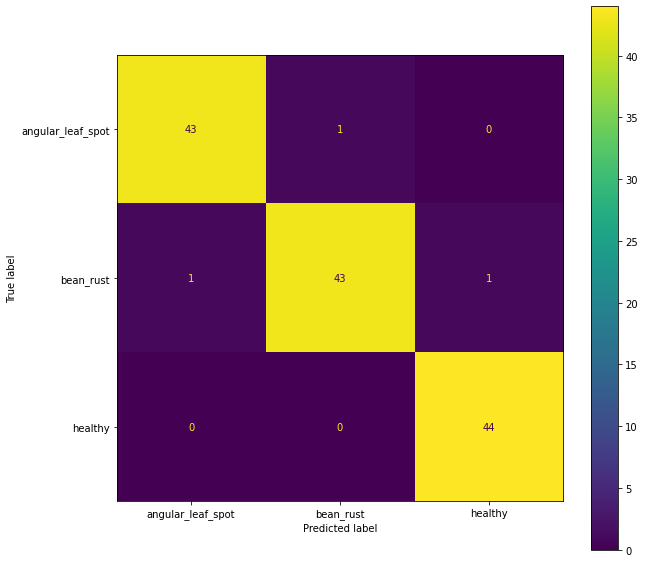

                   precision    recall  f1-score   support

angular_leaf_spot       0.98      0.98      0.98        44
        bean_rust       0.98      0.96      0.97        45
          healthy       0.98      1.00      0.99        44

         accuracy                           0.98       133
        macro avg       0.98      0.98      0.98       133
     weighted avg       0.98      0.98      0.98       133



In [70]:
evaluate(net_test, val_dataloader)

### Evaluate model on Testing Data

Accuracy of the network on the test images: 95.3125 %


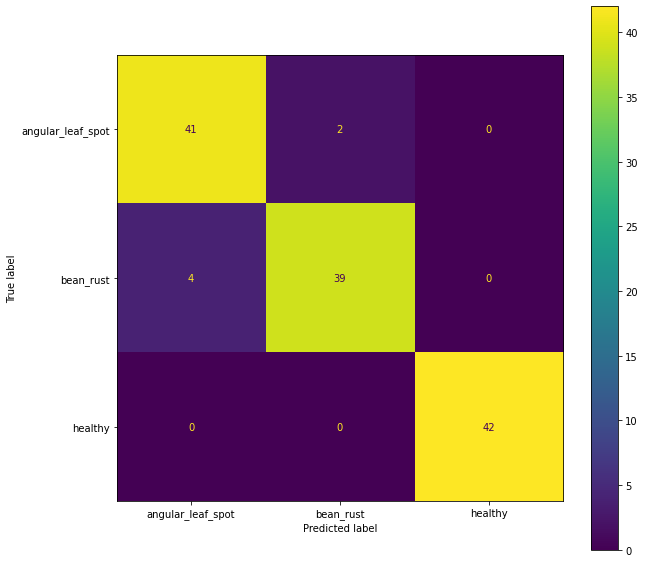

                   precision    recall  f1-score   support

angular_leaf_spot       0.91      0.95      0.93        43
        bean_rust       0.95      0.91      0.93        43
          healthy       1.00      1.00      1.00        42

         accuracy                           0.95       128
        macro avg       0.95      0.95      0.95       128
     weighted avg       0.95      0.95      0.95       128



In [71]:
evaluate(net_test, test_dataloader)